# <center> Classical Benchmarks </center>

Classical benchmarks

## Utilitary libraries

In [1]:
import numpy as np
import odl
import odl.contrib.tensorflow
import math

## Phantom data module

In [2]:
import sys
sys.path.append("../../WF_inpaint/")

In [3]:
# Import the needed modules
from data.data_factory import random_realphantom, random_phantom
from ellipse.ellipseWF_factory import plot_WF, WFupdate, WFupdate_sino

import matplotlib.pyplot as plt
import numpy.random as rnd
import numpy as np
import odl
import matplotlib.pyplot as plt
%matplotlib inline

### Real phantom with WFset generation full and low dose

In [4]:
size = 256
nClasses = 180
lowd = 40
wedge = 40

In [5]:
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)
realphantom, WFpoints, WFclasses,  WFimage = random_realphantom(size, nRegions, npoints_max, nClasses)

# Compute low dose WF image
angles_lowd = np.array([i for i in range(0,180,int(180/lowd))])
# Extracting the wavefront set orientations in the low dose
angles_gt = (np.array(WFclasses).astype(int)[:,0]-1)
angles_gt_lowd = np.array([angle in angles_lowd for angle in angles_gt])
# Generating the new WFpoints and classes
WFpoints_lowd = WFpoints[angles_gt_lowd]
WFclasses_lowd = list(np.array(WFclasses)[angles_gt_lowd])
# Generating the low dose WFimage
WFimage_lowd = np.zeros([size,size])
WFimage_lowd = WFupdate(WFpoints_lowd, WFclasses_lowd, WFimage_lowd)

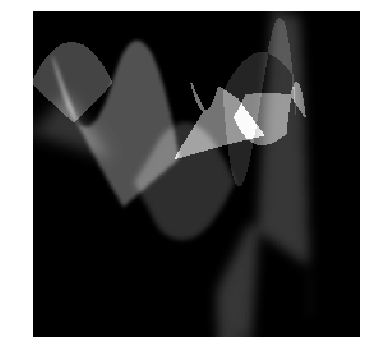

In [6]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(realphantom, cmap="gray")

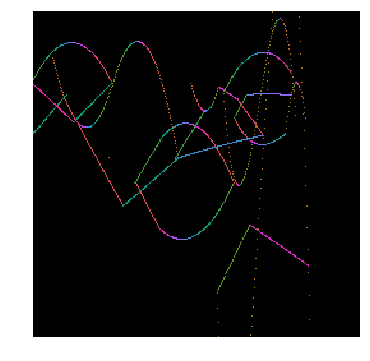

In [7]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)

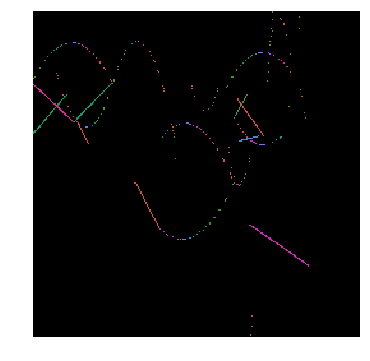

In [8]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_lowd)

### Sinogram of real phantom with WFset generation with full and lowd

In [9]:
from ray_transform.canon_relation import (point_img2sino, class_img2sino, CanRel_img2sino, 
                                         point_sino2img, CanRel_sino2img)

In [10]:
# Create ODL data structures
space = odl.uniform_discr([-int(size/2), -int(size/2)], [int(size/2), int(size/2)], [size, size],
                          dtype='float32')

In [11]:
size = 256
detector_sample = size
impl = 'astra_cuda'

In [12]:
angle_partition_lowd = odl.uniform_partition(0,np.pi,lowd,nodes_on_bdry=True)
angle_partition = odl.uniform_partition(0,np.pi,180,nodes_on_bdry=True)

In [13]:
detector_partition = odl.uniform_partition(-int(size/2),int(size/2),
                                               detector_sample,
                                               nodes_on_bdry=True)

In [14]:
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
geometry_lowd = odl.tomo.Parallel2dGeometry(angle_partition_lowd, detector_partition)


In [15]:
operator = odl.tomo.RayTransform(space, geometry, impl=impl)

In [16]:
n_angles = int((180 - 2 * wedge))
n_angles = math.floor(n_angles)

In [17]:
wedge_pi = wedge * np.pi/180

In [18]:
angle_partition_wedge = odl.uniform_partition(wedge_pi, np.pi-wedge_pi,n_angles, nodes_on_bdry=True)

In [19]:
geometry_wedge = odl.tomo.Parallel2dGeometry(angle_partition_wedge, detector_partition)

In [20]:
operator_wedge = odl.tomo.RayTransform(space, geometry_wedge, impl=impl)

In [21]:
operator_lowd = odl.tomo.RayTransform(space, geometry_lowd, impl=impl)

In [22]:
batch_size = 5
n_iter = 10
n_primal = 5
n_dual = 5

In [23]:
def generate_data_CT_lima(validation=False):
    """Generate a set of random data."""
    if validation:
        n_generate = 1
    else: 
        n_generate = batch_size

    y_arr = np.empty((n_generate, operator_wedge.range.shape[0], operator_wedge.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], 1), dtype='float32')

    for i in range(n_generate):
        if validation:
            phantom = odl.phantom.shepp_logan(space, True)
        else:
            phantom, _, _,  _ = random_realphantom(size, nRegions, npoints_max, nClasses)
        data = operator_wedge(phantom)
        noisy_data = data + odl.phantom.white_noise(operator_wedge.range) * np.mean(np.abs(data)) * 0.05

        x_true_arr[i, ..., 0] = phantom
        y_arr[i, ..., 0] = noisy_data

    return y_arr, x_true_arr

In [24]:
def generate_data_CT_lowd(validation=False):
    """Generate a set of random data."""
    if validation:
        n_generate = 1
    else: 
        n_generate = batch_size

    y_arr = np.empty((n_generate, operator_lowd.range.shape[0], operator_lowd.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], 1), dtype='float32')

    for i in range(n_generate):
        if validation:
            phantom = odl.phantom.shepp_logan(space, True)
        else:
            phantom, _, _,  _ = random_realphantom(size, nRegions, npoints_max, nClasses)
        data = operator_lowd(phantom)
        noisy_data = data + odl.phantom.white_noise(operator_lowd.range) * np.mean(np.abs(data)) * 0.05

        x_true_arr[i, ..., 0] = phantom
        y_arr[i, ..., 0] = noisy_data

    return y_arr, x_true_arr

In [25]:
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

### Data

In [26]:
_, phantom = generate_data_CT_lowd(validation = True)
#phantom = phantom[0,:,:,0]

In [40]:
from PIL import Image
from skimage import data
from skimage.transform import resize

import matplotlib.pyplot as plt
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr
import sys

In [29]:
phantom = np.array(Image.open('../brain.png'))[:,:,0].astype(np.float)
phantom = resize(image, (size,size))/image.max()

In [30]:
sinogram_lowd_odl = operator_lowd(space.element(phantom))
sinogram_wedge_odl = operator_wedge(space.element(phantom))

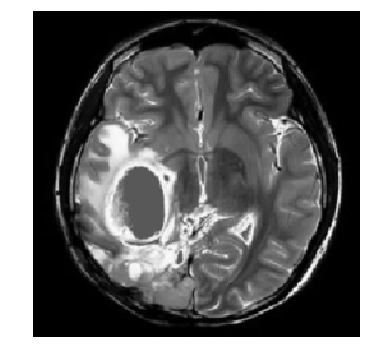

In [31]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(phantom, cmap="gray")

## Filtered Back Projection

The filtered back projection in its discrete form is given by 

$$
f_{FBP}(x,y) = \frac{1}{2\pi}\sum_{i = 0}^{N-1} \Delta\phi_i \tilde{g}(\phi_i,x\cos\phi_i+y\sin\phi_i)
$$
where $\Delta\phi$ is the angular spacing between the projections and $\tilde{g}$ is obtained by filtering the radon transform $g$ with the radon kernel $k(s)$ with frequency response $|\omega|$, i.e.
$$
\tilde{g}(\phi,s) = g(\phi,s) \cdot k(t)
$$

## Lowd

In [32]:
fbp = odl.tomo.analytic.filtered_back_projection.fbp_op(operator)
fbp_lowd = odl.tomo.analytic.filtered_back_projection.fbp_op(operator_lowd)
fbp_wedge = odl.tomo.analytic.filtered_back_projection.fbp_op(operator_wedge)

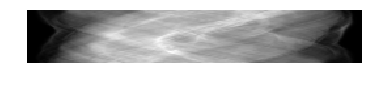

In [33]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(np.array(sinogram_lowd_odl), cmap="gray")

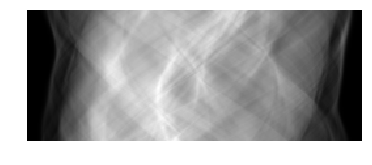

In [34]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(np.array(sinogram_wedge_odl), cmap="gray")

In [35]:
sinogram_lowd_odl = operator_lowd(space.element(phantom))
sinogram_wedge_odl = operator_wedge(space.element(phantom))

In [36]:
phantom_fbp_lowd  = np.array(fbp_lowd(sinogram_lowd_odl))
phantom_fbp_wedge  = np.array(fbp_wedge(sinogram_wedge_odl))

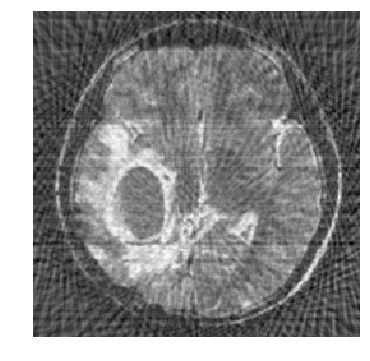

In [37]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(phantom_fbp_lowd, cmap="gray")
plt.savefig('../results_realdata/brain-recon-fbp_lowd40.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [41]:
print("SSIM: ", ssim(phantom_fbp_lowd,phantom))
print("PSNR: ", psnr(phantom_fbp_lowd,phantom, data_range=1))

SSIM:  0.512042883815
PSNR:  19.8936110133


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


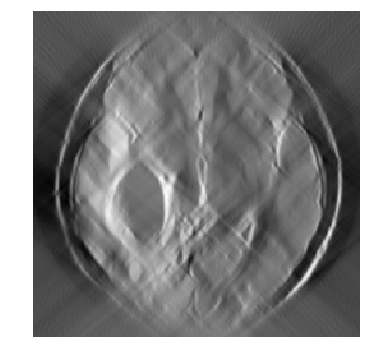

In [38]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(phantom_fbp_wedge, cmap="gray")
plt.savefig('../results_realdata/brain-recon-fbp_wedge40.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [42]:
print("SSIM: ", ssim(phantom_fbp_wedge,phantom))
print("PSNR: ", psnr(phantom_fbp_wedge,phantom, data_range=1))

SSIM:  0.441429725813
PSNR:  14.5262838724


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


## Tikhonov 

Given the data sinogram $g$, the Tikhonov regularization is based on the optimization procedure

$$
\min_{f\in L^2(\mathbb{R}^2)} ||\mathcal{R}f-g||_2^2+||\nabla f||_2^2
$$

this objective function can be optimized using for example, conjugate gradient

In [43]:
# Define parameters and operators
B = odl.Gradient(space)
a = 0.001
T_lowd =  operator_lowd.adjoint * operator_lowd + a * B.adjoint * B
b_lowd = operator_lowd.adjoint(sinogram_lowd_odl)

In [44]:
# Define parameters and operators
B = odl.Gradient(space)
a = 0.001
T_wedge =  operator_wedge.adjoint * operator_wedge + a * B.adjoint * B
b_wedge = operator_wedge.adjoint(sinogram_wedge_odl)

In [45]:
# Conjugate gradient solver
phantom_tik_lowd = space.zero()
odl.solvers.conjugate_gradient(T_lowd, phantom_tik_lowd, b_lowd, niter=200)

In [46]:
# Conjugate gradient solver
phantom_tik_wedge = space.zero()
odl.solvers.conjugate_gradient(T_wedge, phantom_tik_wedge, b_wedge, niter=200)

In [47]:
phantom_tik_lowd = np.array(phantom_tik_lowd)
phantom_tik_wedge = np.array(phantom_tik_wedge)

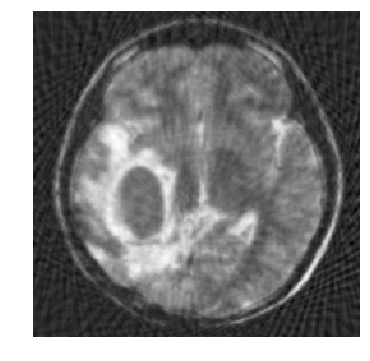

In [48]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(phantom_tik_lowd, cmap="gray")
plt.savefig('../results_realdata/brain-recon-tik_lowd40.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [50]:
print("SSIM: ", ssim(phantom_tik_lowd,phantom))
print("PSNR: ", psnr(phantom_tik_lowd,phantom, data_range=1))

SSIM:  0.738161458347
PSNR:  24.7769448319


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


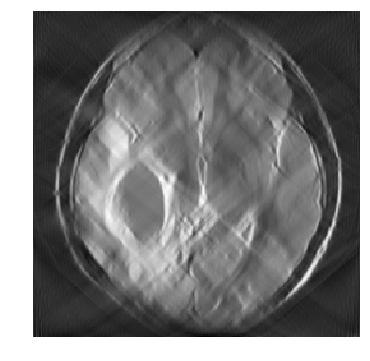

In [49]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(phantom_tik_wedge, cmap="gray")
plt.savefig('../results_realdata/barin-recon-tik_wedge40.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [51]:
print("SSIM: ", ssim(phantom_tik_wedge,phantom))
print("PSNR: ", psnr(phantom_tik_wedge,phantom, data_range=1))

SSIM:  0.730248507387
PSNR:  22.6206951198


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


## TV regularization

Given the data sinogram $g$, the TV regularization is based on the optimization procedure

$$
\min_{f\in L^2(\mathbb{R}^2)} ||\mathcal{R}f-g||_2^2+||\nabla f||_1^2
$$

this objective function can be optimized using for example, conjugate gradient

In [52]:
# Assemble all operators into a list.
grad = odl.Gradient(space)
lin_ops_lowd = [operator_lowd, grad]
a = 0.001

In [53]:
# Assemble all operators into a list.
grad = odl.Gradient(space)
lin_ops_wedge = [operator_wedge, grad]
a = 0.001

In [54]:
# Create functionals for the l2 distance and l1 norm.
g_funcs_lowd= [odl.solvers.L2NormSquared(operator_lowd.range).translated(sinogram_lowd_odl),
           a * odl.solvers.L1Norm(grad.range)]

In [55]:
# Create functionals for the l2 distance and l1 norm.
g_funcs_wedge = [odl.solvers.L2NormSquared(operator_wedge.range).translated(sinogram_wedge_odl),
           a * odl.solvers.L1Norm(grad.range)]

In [56]:
# Functional of the bound constraint 0 <= x <= 1
f_lowd = odl.solvers.IndicatorBox(space, 0, 1)
f_wedge = odl.solvers.IndicatorBox(space, 0, 1)

In [57]:
# Find scaling constants so that the solver converges.
# See the douglas_rachford_pd documentation for more information.
opnorm_lowd = odl.power_method_opnorm(operator_lowd)
opnorm_wedge = odl.power_method_opnorm(operator_wedge)
opnorm_grad = odl.power_method_opnorm(grad)

In [58]:
sigma_lowd = [1 / opnorm_lowd ** 2, 1 / opnorm_grad ** 2]
sigma_wedge = [1 / opnorm_wedge ** 2, 1 / opnorm_grad ** 2]

tau = 1.0

# Solve using the Douglas-Rachford Primal-Dual method
phantom_tv_lowd = space.zero()
phantom_tv_wedge = space.zero()

In [59]:
odl.solvers.douglas_rachford_pd(phantom_tv_lowd, f_lowd, g_funcs_lowd, lin_ops_lowd,
                                tau=tau, sigma=sigma_lowd, niter=80)

In [60]:
odl.solvers.douglas_rachford_pd(phantom_tv_wedge, f_wedge, g_funcs_wedge, lin_ops_wedge,
                                tau=tau, sigma=sigma_wedge, niter=80)

In [61]:
phantom_tv_lowd = np.array(phantom_tv_lowd)
phantom_tv_wedge = np.array(phantom_tv_wedge)

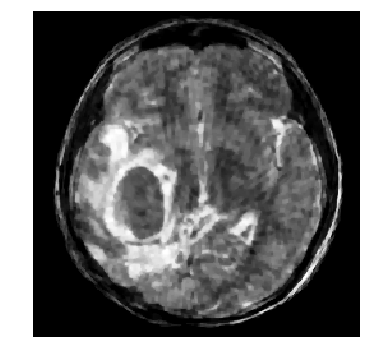

In [62]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(phantom_tv_lowd, cmap="gray")
plt.savefig('../results_realdata/brain-recon-tv_lowd40.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [64]:
print("SSIM: ", ssim(phantom_tv_lowd,phantom))
print("PSNR: ", psnr(phantom_tv_lowd,phantom, data_range=1))

SSIM:  0.880188916643
PSNR:  26.5964341798


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


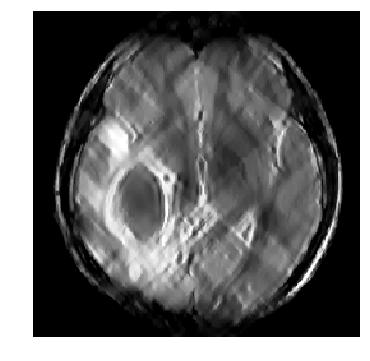

In [63]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(phantom_tv_wedge, cmap="gray")
plt.savefig('../results_realdata/brain-recon-tv_wedge40.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [65]:
print("SSIM: ", ssim(phantom_tv_wedge,phantom))
print("PSNR: ", psnr(phantom_tv_wedge,phantom, data_range=1))

SSIM:  0.836093054358
PSNR:  23.0850707243


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


### Shearlet based sparse regularization

In [66]:
import odl.contrib.pyshearlab

In [67]:
# Create ODL data structures
space_image = odl.uniform_discr([-int(size/2), -int(size/2)], [int(size/2), int(size/2)], [size, size],
                          dtype='float32')

#### Shearlet analysis and synthesis operator

In [68]:
shearan = odl.contrib.pyshearlab.PyShearlabOperator(space_image,num_scales= 4)

In [69]:
# Shearlet synthesis operator
shearsyn = shearan.inverse

In [70]:
# Shearlet coefficietns space
space = shearsyn.domain

#### SherRay transform

In [71]:
shear_ray_lowd = odl.operator.operator.OperatorComp(operator_lowd,shearsyn)

In [72]:
shear_ray_wedge = odl.operator.operator.OperatorComp(operator_wedge,shearsyn)

#### Data and phantom

In [73]:
phantom_shear = shearan(phantom)

### L2 Tikhonov regularization

In [74]:
g_lowd = shear_ray_lowd(phantom_shear)

In [75]:
# Tikhonov with gradient
B = odl.DiagonalOperator(odl.IdentityOperator(space[0]), 49)
a = 0.0001
T_shear_lowd =  shear_ray_lowd.adjoint * shear_ray_lowd + a * B.adjoint * B
b_shear_lowd = shear_ray_lowd.adjoint(g_lowd)

In [76]:
# Conjugate gradient solver
phantom_shear_tik_lowd = space.zero()
odl.solvers.conjugate_gradient(T_shear_lowd, phantom_shear_tik_lowd, b_shear_lowd, niter=200)

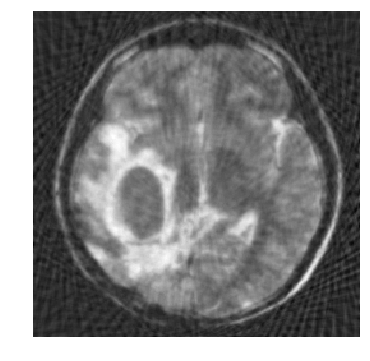

In [77]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(shearsyn(phantom_shear_tik_lowd), cmap="gray")
plt.savefig('../results_realdata/brain-recon-sheartik_lowd40.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [83]:
print("SSIM: ", ssim(shearsyn(phantom_shear_tik_lowd),phantom))
print("PSNR: ", psnr(shearsyn(phantom_shear_tik_lowd),phantom, data_range=1))

SSIM:  0.731234230757
PSNR:  24.6834905098


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


In [84]:
g_wedge = shear_ray_wedge(phantom_shear)

In [85]:
# Tikhonov with gradient
B = odl.DiagonalOperator(odl.IdentityOperator(space[0]), 49)
a = 0.0001
T_shear_wedge=  shear_ray_wedge.adjoint * shear_ray_wedge + a * B.adjoint * B
b_shear_wedge = shear_ray_wedge.adjoint(g_wedge)

In [86]:
# Conjugate gradient solver
phantom_shear_tik_wedge = space.zero()
odl.solvers.conjugate_gradient(T_shear_wedge, phantom_shear_tik_wedge, b_shear_wedge, niter=200)

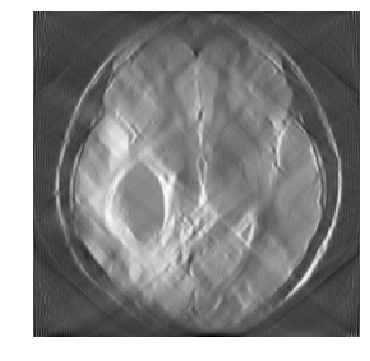

In [87]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(shearsyn(phantom_shear_tik_wedge), cmap="gray")
plt.savefig('../results_realdata/brain-recon-sheartik_wedge40.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [88]:
print("SSIM: ", ssim(shearsyn(phantom_shear_tik_wedge),phantom))
print("PSNR: ", psnr(shearsyn(phantom_shear_tik_wedge),phantom, data_range=1))

SSIM:  0.701783510457
PSNR:  22.197315058


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


### L1 shearlet sparse regularization

In [89]:
# Assemble all operators into a list.
Id = odl.IdentityOperator(space)
lin_ops_lowd = [shear_ray_lowd, Id]
a = 0.001

In [90]:
# Create functionals for the l2 distance and l1 norm.
g_funcs_lowd = [odl.solvers.L2NormSquared(shear_ray_lowd.range).translated(sinogram_lowd_odl),
           a * odl.solvers.L1Norm(Id.range)]

In [91]:
# Functional of the bound constraint 0 <= x <= 1
f_lowd = odl.solvers.IndicatorBox(space, 0, 1)

In [92]:
# Find scaling constants so that the solver converges.
# See the douglas_rachford_pd documentation for more information.
opnorm = odl.power_method_opnorm(shear_ray_lowd)
opnorm_Id = odl.power_method_opnorm(Id)

In [93]:
sigma_lowd = [1 / opnorm_lowd ** 2, 1 / opnorm_Id ** 2]

tau = 1.0

# Solve using the Douglas-Rachford Primal-Dual method
phantom_shear_tv_lowd = space.zero()

In [94]:
odl.solvers.douglas_rachford_pd(phantom_shear_tv_lowd, f_lowd, g_funcs_lowd, lin_ops_lowd,
                                tau=tau, sigma=sigma_lowd, niter=80)

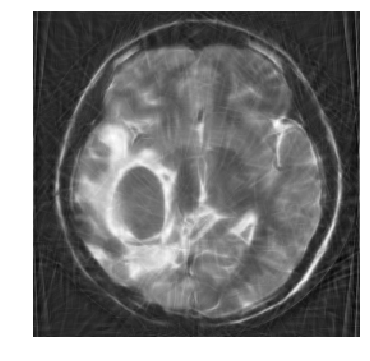

In [95]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(shearsyn(phantom_shear_tv_lowd), cmap="gray")
plt.savefig('../results_realdata/brain-recon-sheartv_lowd40.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [96]:
print("SSIM: ", ssim(shearsyn(phantom\_shear_tv_lowd),phantom))
print("PSNR: ", psnr(shearsyn(phantom_shear_tv_lowd),phantom, data_range=1))

SSIM:  0.777429535345
PSNR:  25.420362892


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


In [97]:
# Assemble all operators into a list.
Id = odl.IdentityOperator(space)
lin_ops_wedge = [shear_ray_wedge, Id]
a = 0.001

In [98]:
# Create functionals for the l2 distance and l1 norm.
g_funcs_wedge = [odl.solvers.L2NormSquared(shear_ray_wedge.range).translated(sinogram_wedge_odl),
           a * odl.solvers.L1Norm(Id.range)]

In [99]:
# Functional of the bound constraint 0 <= x <= 1
f_wedge = odl.solvers.IndicatorBox(space, 0, 1)

In [100]:
# Find scaling constants so that the solver converges.
# See the douglas_rachford_pd documentation for more information.
opnorm = odl.power_method_opnorm(shear_ray_wedge)
opnorm_Id = odl.power_method_opnorm(Id)

In [101]:
sigma_wedge = [1 / opnorm_wedge ** 2, 1 / opnorm_Id ** 2]

tau = 1.0

# Solve using the Douglas-Rachford Primal-Dual method
phantom_shear_tv_wedge = space.zero()

In [102]:
odl.solvers.douglas_rachford_pd(phantom_shear_tv_wedge, f_wedge, g_funcs_wedge, lin_ops_wedge,
                                tau=tau, sigma=sigma_wedge, niter=80)

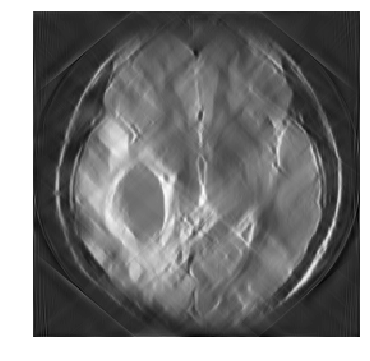

In [103]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(shearsyn(phantom_shear_tv_wedge), cmap="gray")
plt.savefig('../results_realdata/brain-recon-sheartv_wedge40.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [104]:
print("SSIM: ", ssim(shearsyn(phantom_shear_tv_wedge),phantom))
print("PSNR: ", psnr(shearsyn(phantom_shear_tv_wedge),phantom, data_range=1))

SSIM:  0.72631618994
PSNR:  22.2906869291


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """Entry point for launching an IPython kernel.
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  
